In [ ]:
!pip install gymnasium
!pip install pygame

# Carga y exploración de un entorno de Gymnasium

In [28]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed

SEED = 42

acciones = ['←', '↓', '→', '↑']

# Función para mostrar el entorno con emojis
def render_frozenlake_with_emojis(desc, agent_pos):
    EMOJI_MAP = {b'S': '🚩', b'F': '🧊', b'H': '💀', b'G': '🏁'}
    AGENT_EMOJI = '🐧'
    grid = ""
    for i, row in enumerate(desc):
        for j, cell in enumerate(row):
            pos = i * desc.shape[1] + j
            if pos == agent_pos:
                grid += AGENT_EMOJI
            else:
                grid += EMOJI_MAP[cell]
        grid += "<br>"
    clear_output(wait=True)
    display(HTML(f"<pre style='font-size: 24px'>{grid}</pre>"))


# Política epsilon-soft. Se usa para el entrenamiento
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    pi_A[best_action] += (1.0 - epsilon)
    return pi_A

# Política epsilon-greedy a partir de una epsilon-soft
def epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = random_epsilon_greedy_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=pi_A)

# Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
# Visualización de la política aprendida (greedy)
def pi_star_from_Q(agente):
    env = agente.env
    Q = agente.Q
    desc = env.unwrapped.desc
    state, info = agente.env.reset()
    done = False
    total_reward = 0
    action_sequence = []
    while not done:
        render_frozenlake_with_emojis(desc, state)
        action = np.argmax(Q[state])
        action_sequence.append(acciones[action])
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

    render_frozenlake_with_emojis(desc, state)
    print(f"Recompensa total siguiendo la política greedy: {total_reward}")
    print(f"Secuencia de acciones tomadas: {action_sequence}")

# Tabla con la mejor acción por estado
def obtener_politica_optima(agente):
    Q = agente.Q
    desc = agente.env.unwrapped.desc
    num_cols = desc.shape[1]
    transiciones = {
        0: lambda s: s - 1,
        1: lambda s: s + num_cols,
        2: lambda s: s + 1,
        3: lambda s: s - num_cols
    }
    mejores_acciones = []
    simbolos = []
    siguiente_estado = []

    for i, fila in enumerate(Q):
        if np.all(fila == 0):
            simbolos.append('X')
            siguiente_estado.append("-")
        else:
            a = np.argmax(fila)
            mejores_acciones.append(a)
            simbolos.append(acciones[a])
            try:
                destino = transiciones[a](i)
                if 0 <= destino < len(Q):
                    siguiente_estado.append(f"Estado {destino}")
                else:
                    siguiente_estado.append(None)
            except:
                siguiente_estado.append(None)

    df = pd.DataFrame({
        'Mejor acción': simbolos,
        'Estado siguiente': siguiente_estado
    }, index=[f"Estado {i}" for i in range(len(simbolos))])
    display(df)

# Objeto AgenteMonteCarlo (off policy)

In [35]:
class AgenteMonteCarloOffPolicy:
     def __init__(self, env, epsilon=0.3, discount_factor=1.0):
        self.env = env
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.nA = env.action_space.n
        self.Q = np.zeros([env.observation_space.n, self.nA])
        self.C = np.zeros_like(self.Q)  # acumulador de pesos
        self.stats = []
        self.episode_lengths = []

     def entrenar(self, num_episodes=50000, mostrar_barra=True):
    
        random.seed(SEED)
        np.random.seed(SEED)
        self.env.reset(seed=SEED)
        self.env.action_space.seed(SEED)
        self.env.observation_space.seed(SEED)
    
        acumulador_recompensas = 0.0
    
        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            state, _ = self.env.reset()
            episode = []
            done = False
    
            # Generar episodio con política de comportamiento ε-greedy
            while not done:
                action = epsilon_greedy_policy(self.Q, self.epsilon, state, self.nA)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state
                done = terminated or truncated
    
            self.episode_lengths.append(len(episode))
    
            G = 0
            W = 1.0
    
            # Procesar episodio hacia atrás
            for i in reversed(range(len(episode))):
                s, a, r = episode[i]
                G = self.discount_factor * G + r

                # Actualización de C y Q antes del corte
                self.C[s, a] += W
                self.Q[s, a] += (W / self.C[s, a]) * (G - self.Q[s, a])

                # Actualizar política objetivo π(s) implícitamente como greedy
                a_star = np.argmax(self.Q[s])

                # Si la acción tomada no coincide con la nueva política π(s), cortar
                if a != a_star:
                    break

                # Política de comportamiento (ε-greedy)
                prob_b = self.epsilon / self.nA
                prob_b += (1 - self.epsilon) if a == a_star else 0

                W *= 1.0 / prob_b
                if W == 0:
                    break
    
            acumulador_recompensas += G
            self.stats.append(acumulador_recompensas / (t + 1))
    
        return self.Q

# Entorno 4X4

In [53]:
def evaluar_configuracion(params, map_name):
    if isinstance(map_name, str):
        env = gym.make("FrozenLake-v1", is_slippery=False, map_name=map_name)
    else:
        env = gym.make("FrozenLake-v1", is_slippery=False, desc=map_name)
    gamma, epsilon = params
    agente = AgenteMonteCarloOffPolicy(env, epsilon=epsilon, discount_factor=gamma)
    agente.entrenar(num_episodes=29000, mostrar_barra=False)
    recompensa_final = agente.stats[-1]
    return (gamma, epsilon, recompensa_final)

def grid_search(map_name):
    # Espacio de búsqueda
    gammas = np.linspace(0.1, 1.0, 10)
    epsilons = np.linspace(0.1, 1.0, 10)
    combinaciones = list(product(gammas, epsilons))

    mejor_config = None
    mejor_recompensa = -float('inf')
    resultados = []

    print("🔍 Buscando la mejor combinación de hiperparámetros...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo, map_name) for combo in combinaciones]
        
        with tqdm(total=len(futures), desc="Progreso") as pbar:
            for future in as_completed(futures):
                gamma, epsilon, recompensa = future.result()
                resultados.append((gamma, epsilon, recompensa))

                if recompensa > mejor_recompensa:
                    mejor_recompensa = recompensa
                    mejor_config = (gamma, epsilon)

                # Actualizar el postfix de tqdm
                pbar.set_postfix({
                    "γ": round(mejor_config[0], 2),
                    "ε": round(mejor_config[1], 2),
                    "reward": f"{mejor_recompensa:.2f}"
                })
                pbar.update(1)

    print("\n✅ Mejor configuración encontrada:")
    print(f" γ = {mejor_config[0]}, ε = {mejor_config[1]}")
    print(f"  → Recompensa media final: {mejor_recompensa:.4f}")

In [37]:
grid_search("4x4")

🔍 Buscando la mejor combinación de hiperparámetros...



Progreso: 100%|██████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it, γ=1, ε=0.3, reward=0.47]


✅ Mejor configuración encontrada:
 γ = 1.0, ε = 0.30000000000000004
  → Recompensa media final: 0.4728


In [43]:
# Ejecución de ejemplo
env_4x4 = gym.make("FrozenLake-v1", is_slippery=False)
env_4x4.reset(seed=SEED)
agente_4x4 = AgenteMonteCarloOffPolicy(env_4x4, epsilon=0.3, discount_factor=1.0)
agente_4x4.entrenar(num_episodes=200000)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [01:21<00:00, 2446.85it/s]


array([[0.9551977 , 0.99872759, 0.96831432, 0.99450528],
       [0.97542753, 0.        , 0.9975722 , 0.99117662],
       [0.98189591, 0.99547109, 0.9917148 , 0.99498786],
       [0.9961073 , 0.        , 0.94345621, 0.93099446],
       [0.94821055, 0.99954184, 0.        , 0.99223685],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99994632, 0.        , 0.99562784],
       [0.        , 0.        , 0.        , 0.        ],
       [0.98092393, 0.        , 0.99978179, 0.99686771],
       [0.99830791, 0.99528493, 0.99997318, 0.        ],
       [0.99976976, 0.99996454, 0.        , 0.98770393],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9968815 , 0.9992408 , 1.        ],
       [0.99955472, 0.99991308, 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        ]])

# Gráfica de Proporción de aciertos por número de episodios

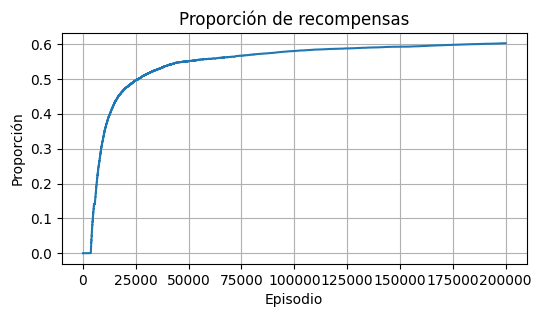

In [44]:
def plot_hit_proportion(agente):
    stats = agente.stats
    indices = list(range(len(stats)))
    plt.figure(figsize=(6, 3))
    plt.plot(indices, stats)
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    plt.show()

plot_hit_proportion(agente_4x4)

# Gráfica de longitud de los episodios

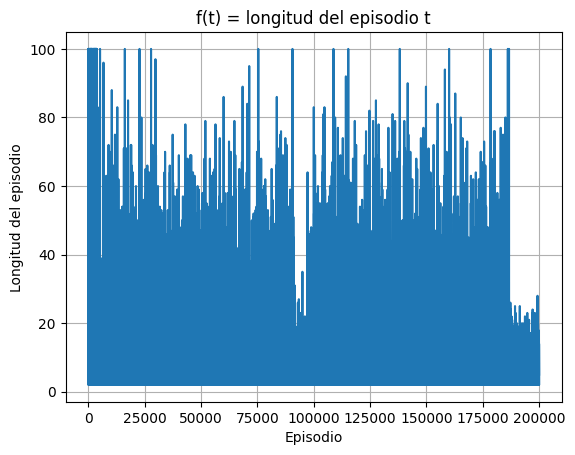

In [45]:
def plot_episode_length(agente):
    episode_lengths = agente.episode_lengths
    plt.plot(episode_lengths)
    plt.title("f(t) = longitud del episodio t")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud del episodio")
    plt.grid(True)
    plt.show()
    
plot_episode_length(agente_4x4)

## Interpretación de las gráficas:

1. La primera gráfica muestra la proporción acumulada de recompensas por episodio. Se observa una tendencia ascendente que se estabiliza, lo cual indica que el agente ha aprendido una política que mejora progresivamente su rendimiento. La proporción final cercana a 0.5 sugiere que logra alcanzar el objetivo en aproximadamente la mitad de los episodios.

2. La segunda gráfica representa la longitud de cada episodio (número de pasos hasta terminar). Inicialmente, el agente necesita más pasos y los episodios son inestables. A medida que aprende, la longitud tiende a estabilizarse y reducirse, lo cual indica que el agente encuentra trayectorias más eficientes o termina el episodio de forma más consistente.

Ambas gráficas son complementarias: mientras que una muestra la eficacia del agente, la otra muestra su eficiencia y estabilidad.

In [42]:
pi_star_from_Q(agente_4x4)

# Mostrar la tabla Q aprendida
print("Valores Q aprendidos por estado y acción:")
q_table = pd.DataFrame(agente_4x4.Q, columns=['← Izquierda', '↓ Abajo', '→ Derecha', '↑ Arriba'])
q_table.index.name = 'Estado'
display(q_table.round(3))

# Mostrar política óptima
print("\nPolítica óptima aprendida (mejor acción por estado):")
obtener_politica_optima(agente_4x4)

Recompensa total siguiendo la política greedy: 1.0
Secuencia de acciones tomadas: ['↓', '↓', '→', '→', '↓', '→']
Valores Q aprendidos por estado y acción:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.830,0.994,0.626,0.978
1,0.906,0.000,0.926,0.000
2,0.722,0.967,0.973,0.000
3,0.980,0.000,1.000,0.908
4,0.799,0.998,0.000,0.967
5,0.000,0.000,0.000,0.000
6,0.000,1.000,0.000,1.000
7,0.000,0.000,0.000,0.000
8,0.921,0.000,0.999,0.986



Política óptima aprendida (mejor acción por estado):


,Mejor acción,Estado siguiente
Estado 0,↓,Estado 4
Estado 1,→,Estado 2
Estado 2,→,Estado 3
Estado 3,→,Estado 4
Estado 4,↓,Estado 8
Estado 5,X,-
Estado 6,↓,Estado 10
Estado 7,X,-
Estado 8,→,Estado 9
Estado 9,→,Estado 10


# Entorno 8x8

In [54]:
grid_search("8x8")

🔍 Buscando la mejor combinación de hiperparámetros...



Progreso: 100%|████████████████████████████████████████████████| 100/100 [21:49<00:00, 13.09s/it, γ=1, ε=1, reward=0.00]


✅ Mejor configuración encontrada:
 γ = 1.0, ε = 1.0
  → Recompensa media final: 0.0013


In [55]:
# Ejecución de ejemplo
env_8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8")
env_8x8.reset(seed=SEED)
agente_8x8 = AgenteMonteCarloOffPolicy(env_8x8, epsilon=1.0, discount_factor=1.0)
agente_8x8.entrenar(num_episodes=200000)

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [04:49<00:00, 690.81it/s]


array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99997562, 0.        , 0.        ],
       [0.999998  , 0.99999966, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        ,

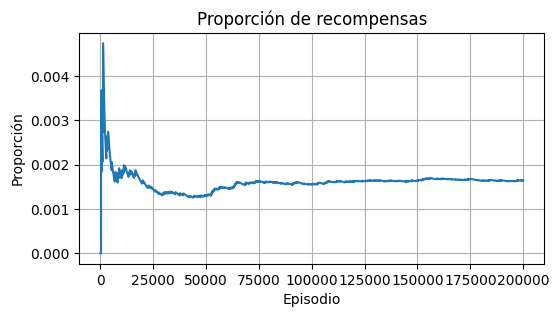

In [56]:
plot_hit_proportion(agente_8x8)

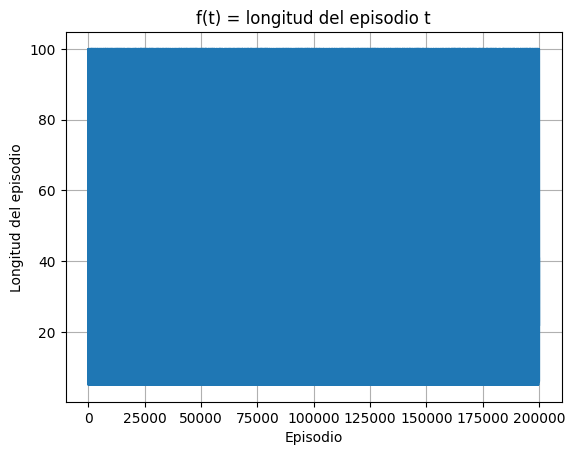

In [57]:
plot_episode_length(agente_8x8)

In [58]:
pi_star_from_Q(agente_8x8)

# Mostrar la tabla Q aprendida
print("Valores Q aprendidos por estado y acción:")
q_table = pd.DataFrame(agente_8x8.Q, columns=['← Izquierda', '↓ Abajo', '→ Derecha', '↑ Arriba'])
q_table.index.name = 'Estado'
display(q_table.round(3))

# Mostrar política óptima
print("\nPolítica óptima aprendida (mejor acción por estado):")
obtener_politica_optima(agente_8x8)

Recompensa total siguiendo la política greedy: 0.0
Secuencia de acciones tomadas: ['←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←', '←']
Valores Q aprendidos por estado y acción:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.000,0.0,0.000,0.0
1,0.000,0.0,0.000,0.0
2,0.000,0.0,0.000,0.0
3,0.000,0.0,0.000,0.0
4,0.000,0.0,0.000,0.0
...,...,...,...,...
59,0.000,0.0,0.000,0.0
60,0.000,0.0,1.000,0.0
61,0.877,0.0,0.909,0.0



Política óptima aprendida (mejor acción por estado):


,Mejor acción,Estado siguiente
Estado 0,X,-
Estado 1,X,-
Estado 2,X,-
Estado 3,X,-
Estado 4,X,-
...,...,...
Estado 59,X,-
Estado 60,→,Estado 61
Estado 61,→,Estado 62
Estado 62,↓,None
